## import libraries

In [1]:
import glob
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import calendar

from os import listdir

filepaths = [f for f in listdir("./data") if f.endswith('.csv')]
df = pd.concat(map(pd.read_csv, filepaths))

OR

df = pd.concat(map(pd.read_csv, ['data/d1.csv', 'data/d2.csv','data/d3.csv']))

## import data

In [2]:
df_all = pd.concat(map(pd.read_csv, glob.glob('data/*.csv')))

In [3]:
df_all.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'friends',
       'fx_rate', 'goal', 'id', 'is_backing', 'is_starrable', 'is_starred',
       'launched_at', 'location', 'name', 'permissions', 'photo', 'pledged',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type'],
      dtype='object')

In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213583 entries, 0 to 3679
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             213583 non-null  int64  
 1   blurb                     213576 non-null  object 
 2   category                  213583 non-null  object 
 3   converted_pledged_amount  213583 non-null  int64  
 4   country                   213583 non-null  object 
 5   country_displayable_name  213583 non-null  object 
 6   created_at                213583 non-null  int64  
 7   creator                   213583 non-null  object 
 8   currency                  213583 non-null  object 
 9   currency_symbol           213583 non-null  object 
 10  currency_trailing_code    213583 non-null  bool   
 11  current_currency          213583 non-null  object 
 12  deadline                  213583 non-null  int64  
 13  disable_communication     213583 non-null  boo

In [5]:
df_all.shape

(213583, 38)

## data preprocessing

### for null and other inapplicable columns

In [6]:
# drop columns containing with very few non-null
df = df_all.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1, inplace=False)

In [7]:
# drop columns with data that already exist elsewhere in the dataset
df.drop(['profile', 'slug', 'converted_pledged_amount', 'country_displayable_name', 'pledged'], 
        axis=1, inplace=True)

In [8]:
# drop columns that contain data exclusive to a single or very few campaigns
df.drop(['creator', 'location', 'source_url', 'urls'], axis=1, inplace=True)

In [9]:
# drop columns that contain data not set up for use in this analysis
df.drop(['photo', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 
         'fx_rate', 'usd_type'], axis=1, inplace=True)

In [10]:
#drop columns which are indicated or dependent on the target
df.drop(['spotlight', 'state_changed_at'], axis=1, inplace=True)

In [11]:
# Drop disable_communication - bools are all false
df.drop('disable_communication', axis=1, inplace=True)

### for datetime columns

In [12]:
# Converting dates from unix to datetime
date_cols = ['created_at', 'deadline', 'launched_at']
for col in date_cols:
    df[[col]] = pd.to_datetime(df[col], origin='unix', unit='s')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213583 entries, 0 to 3679
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   backers_count    213583 non-null  int64         
 1   blurb            213576 non-null  object        
 2   category         213583 non-null  object        
 3   country          213583 non-null  object        
 4   created_at       213583 non-null  datetime64[ns]
 5   deadline         213583 non-null  datetime64[ns]
 6   goal             213583 non-null  float64       
 7   id               213583 non-null  int64         
 8   is_starrable     213583 non-null  bool          
 9   launched_at      213583 non-null  datetime64[ns]
 10  name             213583 non-null  object        
 11  staff_pick       213583 non-null  bool          
 12  state            213583 non-null  object        
 13  static_usd_rate  213583 non-null  float64       
 14  usd_pledged      21358

### for duplicate rows

In [ ]:
#see possible duplicate rows by 'id'
df.duplicated(subset='id').sum()

In [ ]:
#see possible duplicate rows by 'blurb'
df.duplicated(subset='blurb').sum()

In [ ]:
ids = df["id"]
df[ids.isin(ids[ids.duplicated()])]

In [ ]:
blurbs = df["blurb"]
df[blurbs.isin(blurbs[blurbs.duplicated()])]

In [ ]:
#see 'id' for rows where blurbs are duplicates
df[blurbs.isin(blurbs[blurbs.duplicated()])]['id']

explore ids #175864201 and #262646351 where blurbs are identical but ids are not identical;
per below, choosing to keep observations for ids #175864201 and #262646351

In [ ]:
df.iloc[2561]

In [ ]:
df.iloc[2994]

In [ ]:
df.iloc[2561] == df.iloc[2994]

### extracting categories and subcategories

In [14]:
# Example category value
df.iloc[0]['category']

'{"id":356,"name":"Woodworking","slug":"crafts/woodworking","position":14,"parent_id":26,"parent_name":"Crafts","color":16744876,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/crafts/woodworking"}}}'

In [15]:
# Extracting the relevant sub-category section from the string
f = lambda x: x['category'].split('/')[1].split('","position')[0]
df['sub_category'] = df.apply(f, axis=1)

# Extracting the relevant category section from the string, and replacing the original category variable
f = lambda x: x['category'].split('"slug":"')[1].split('/')[0]
df['category'] = df.apply(f, axis=1)
f = lambda x: x['category'].split('","position"')[0] # Some categories do not have a sub-category, so do not have a '/' to split with
df['category'] = df.apply(f, axis=1)

### calculating additional features

In [16]:
# Time between creating and launching a project
df['creation_to_launch_days'] = df['launched_at'] - df['created_at']
df['creation_to_launch_days'] = df['creation_to_launch_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only
# Or could show as number of hours:
# df['creation_to_launch_hours'] = df['launched_at'] - df['created_at']
# df['creation_to_launch_hours'] = df['creation_to_launch_hours'].dt.round('h') / np.timedelta64(1, 'h') 

# Campaign length
df['campaign_days'] = df['deadline'] - df['launched_at']
df['campaign_days'] = df['campaign_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only

# Launch day of week
df['launch_day'] = df['launched_at'].dt.day_name()

# Deadline day of week
df['deadline_day'] = df['deadline'].dt.day_name()

# Launch month
df['launch_month'] = df['launched_at'].dt.month_name()

# Deadline month
df['deadline_month'] = df['deadline'].dt.month_name()

In [17]:
# Launch time
df['launch_hour'] = df['launched_at'].dt.hour # Extracting hour from launched_at

def two_hour_launch(row):
    '''Creates two hour bins from the launch_hour column'''
    if row['launch_hour'] in (0,1):
        return '12am-2am'
    if row['launch_hour'] in (2,3):
        return '2am-4am'
    if row['launch_hour'] in (4,5):
        return '4am-6am'
    if row['launch_hour'] in (6,7):
        return '6am-8am'
    if row['launch_hour'] in (8,9):
        return '8am-10am'
    if row['launch_hour'] in (10,11):
        return '10am-12pm'
    if row['launch_hour'] in (12,13):
        return '12pm-2pm'
    if row['launch_hour'] in (14,15):
        return '2pm-4pm'
    if row['launch_hour'] in (16,17):
        return '4pm-6pm'
    if row['launch_hour'] in (18,19):
        return '6pm-8pm'
    if row['launch_hour'] in (20,21):
        return '8pm-10pm'
    if row['launch_hour'] in (22,23):
        return '10pm-12am'
    
df['launch_time'] = df.apply(two_hour_launch, axis=1) # Calculates bins from launch_time

df.drop('launch_hour', axis=1, inplace=True)

In [18]:
# Deadline time
df['deadline_hour'] = df['deadline'].dt.hour # Extracting hour from deadline

def two_hour_deadline(row):
    '''Creates two hour bins from the deadline_hour column'''
    if row['deadline_hour'] in (0,1):
        return '12am-2am'
    if row['deadline_hour'] in (2,3):
        return '2am-4am'
    if row['deadline_hour'] in (4,5):
        return '4am-6am'
    if row['deadline_hour'] in (6,7):
        return '6am-8am'
    if row['deadline_hour'] in (8,9):
        return '8am-10am'
    if row['deadline_hour'] in (10,11):
        return '10am-12pm'
    if row['deadline_hour'] in (12,13):
        return '12pm-2pm'
    if row['deadline_hour'] in (14,15):
        return '2pm-4pm'
    if row['deadline_hour'] in (16,17):
        return '4pm-6pm'
    if row['deadline_hour'] in (18,19):
        return '6pm-8pm'
    if row['deadline_hour'] in (20,21):
        return '8pm-10pm'
    if row['deadline_hour'] in (22,23):
        return '10pm-12am'
    
df['deadline_time'] = df.apply(two_hour_deadline, axis=1) # Calculates bins from launch_time

df.drop('deadline_hour', axis=1, inplace=True)

In [19]:
# Mean pledge per backer
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)

In [20]:
# Calculate new column 'usd_goal' as goal * static_usd_rate
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

### target

In [21]:
df = df[df['state'].isin(['successful', 'failed'])]

### setting the index

In [22]:
# Setting the id column as the index
df.set_index('id', inplace=True)

In [23]:
df.head()

,backers_count,blurb,category,country,created_at,deadline,goal,is_starrable,launched_at,name,...,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer,usd_goal
id,,,,,,,,,,,,,,,,,,,,,
2139821925,4,Looking for donations and feedback on my ideas...,crafts,US,2015-12-04 03:38:52,2016-01-03 16:41:03,1000.0,False,2015-12-04 16:41:03,Wood butcher block,...,1,30,Friday,Sunday,December,January,4pm-6pm,4pm-6pm,50.00,1000.00
378093839,545,Logan McBride was a magical girl with a destin...,comics,US,2017-05-06 17:40:01,2017-09-29 00:00:00,20000.0,False,2017-08-29 14:00:07,DESTINY NY: Volume Two -- ONE HOUR LEFT!,...,115,30,Tuesday,Friday,August,September,2pm-4pm,12am-2am,49.12,20000.00
1484057434,267,Wonderful 3D Popup Christmas Cards. Opening th...,crafts,DE,2015-10-08 07:24:00,2015-11-08 21:00:00,2500.0,False,2015-10-16 01:09:33,"Wonderful 3D Popup Christmas Cards: Small, Yet...",...,8,24,Friday,Sunday,October,November,12am-2am,8pm-10pm,43.65,2847.66
1955625514,96,Hi everyone. I love animals and I love to croc...,crafts,CA,2019-01-14 17:46:58,2019-02-20 16:03:10,100.0,False,2019-01-21 16:03:10,Animal Scarves to Help the Animals!,...,7,30,Monday,Wednesday,January,February,4pm-6pm,4pm-6pm,17.10,75.41
814342621,444,"Slim, Earth-friendly hangers with an innovativ...",design,US,2018-05-29 01:14:34,2020-08-22 14:56:04,7500.0,False,2020-07-13 14:56:04,Mozu Hanger - The Friendliest Hanger on the Pl...,...,777,40,Monday,Saturday,July,August,2pm-4pm,2pm-4pm,60.25,7500.00


In [24]:
# Dropping goal and static_usd_rate
df.drop(['goal', 'static_usd_rate'], axis=1, inplace=True)

In [25]:
# Drop blurb variable
df.drop('blurb', axis=1, inplace=True)

df.to_csv('data/processed_data.csv')

## EDA

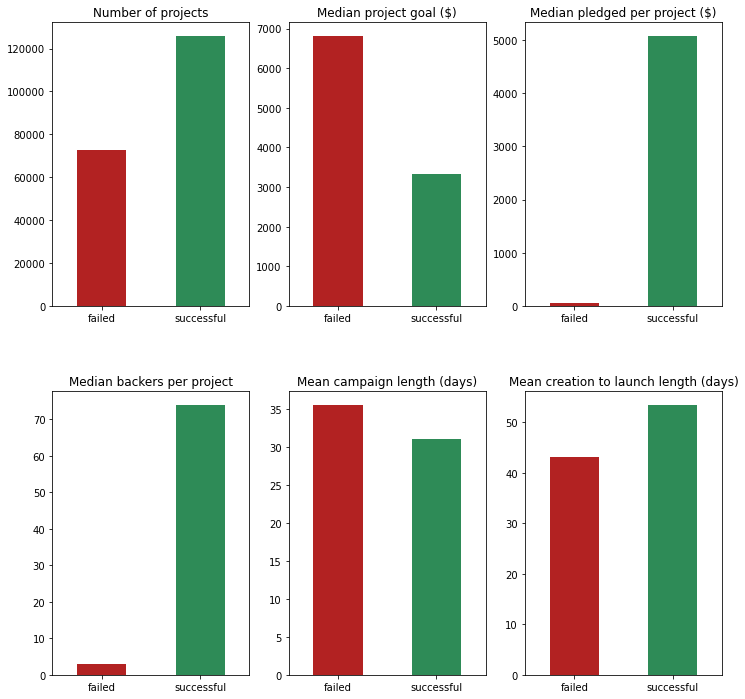

In [26]:
# Plotting the average amount pledged to successful and unsuccesful projects
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,12))

df['state'].value_counts(ascending=True).plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'], rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('state').usd_goal.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'], rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('state').usd_pledged.median().plot(kind='bar', ax=ax3, color=['firebrick', 'seagreen'], rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

df.groupby('state').backers_count.median().plot(kind='bar', ax=ax4, color=['firebrick', 'seagreen'], rot=0)
ax4.set_title('Median backers per project')
ax4.set_xlabel('')

df.groupby('state').campaign_days.mean().plot(kind='bar', ax=ax5, color=['firebrick', 'seagreen'], rot=0)
ax5.set_title('Mean campaign length (days)')
ax5.set_xlabel('')

df.groupby('state').creation_to_launch_days.mean().plot(kind='bar', ax=ax6, color=['firebrick', 'seagreen'], rot=0)
ax6.set_title('Mean creation to launch length (days)')
ax6.set_xlabel('')

# df.groupby('state').name_length.mean().plot(kind='bar', ax=ax7, color=['firebrick', 'seagreen'], rot=0)
# ax7.set_title('Mean name length (words)')
# ax7.set_xlabel('')

# df.groupby('state').blurb_length.mean().plot(kind='bar', ax=ax8, color=['firebrick', 'seagreen'], rot=0)
# ax8.set_title('Mean blurb length (words)')
# ax8.set_xlabel('')

# # Creating a dataframe grouped by staff_pick with columns for failed and successful
# pick_df = pd.get_dummies(df.set_index('staff_pick').state).groupby('staff_pick').sum()
# # Normalizes counts by column, and selects the 'True' category (iloc[1])
# (pick_df.div(pick_df.sum(axis=0), axis=1)).iloc[1].plot(kind='bar', ax=ax9, color=['firebrick', 'seagreen'], rot=0) 
# ax9.set_title('Proportion that are staff picks')
# ax9.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

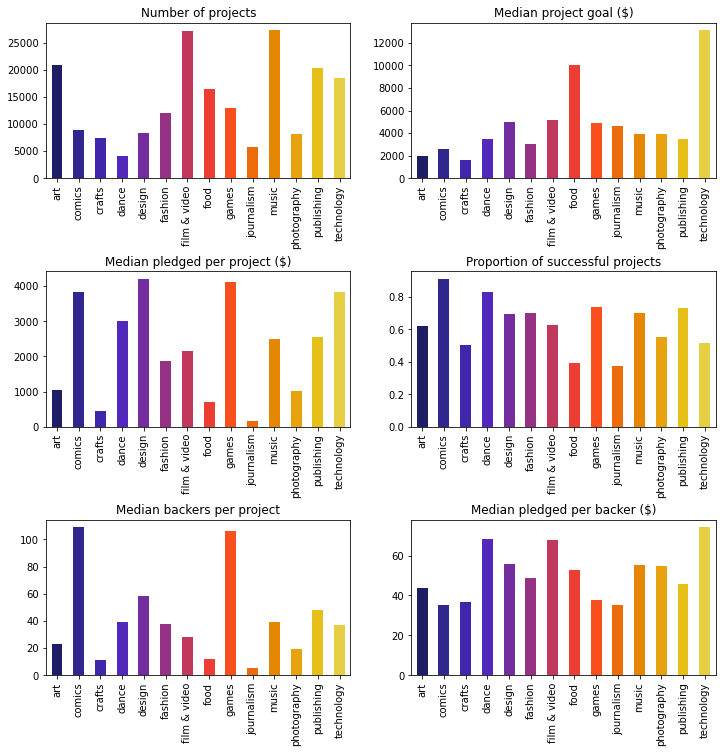

In [27]:
# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(df.set_index('category').state).groupby('category').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.category.nunique())) # Setting a colormap

df.groupby('category').category.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('category').usd_goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('category').usd_pledged.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

cat_df.div(cat_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('category').backers_count.median().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('category').pledge_per_backer.median().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.6)
plt.show()

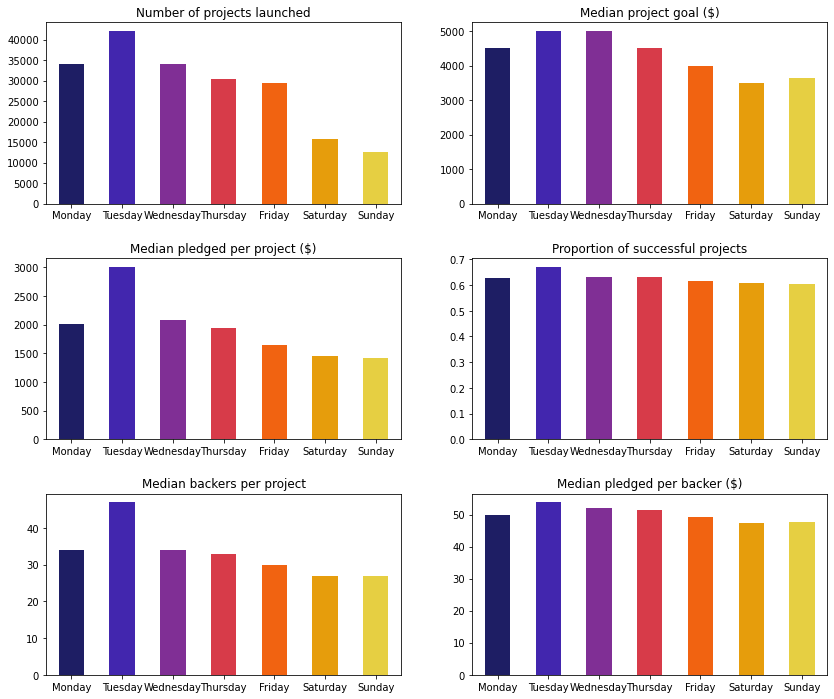

In [28]:
# Creating a dataframe grouped by the day on which they were launched, with columns for failed and successful
day_df = pd.get_dummies(df.set_index('launch_day').state).groupby('launch_day').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_day.nunique()))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df.groupby('launch_day').launch_day.count().reindex(weekdays).plot(kind='bar', ax=ax1, color=color, rot=0)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')

df.groupby('launch_day').usd_goal.median().reindex(weekdays).plot(kind='bar', ax=ax2, color=color, rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('launch_day').usd_pledged.median().reindex(weekdays).plot(kind='bar', ax=ax3, color=color, rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

day_df.div(day_df.sum(axis=1), axis=0).successful.reindex(weekdays).plot(kind='bar', ax=ax4, color=color, rot=0) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('launch_day').backers_count.median().reindex(weekdays).plot(kind='bar', ax=ax5, color=color, rot=0)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('launch_day').pledge_per_backer.median().reindex(weekdays).plot(kind='bar', ax=ax6, color=color, rot=0)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

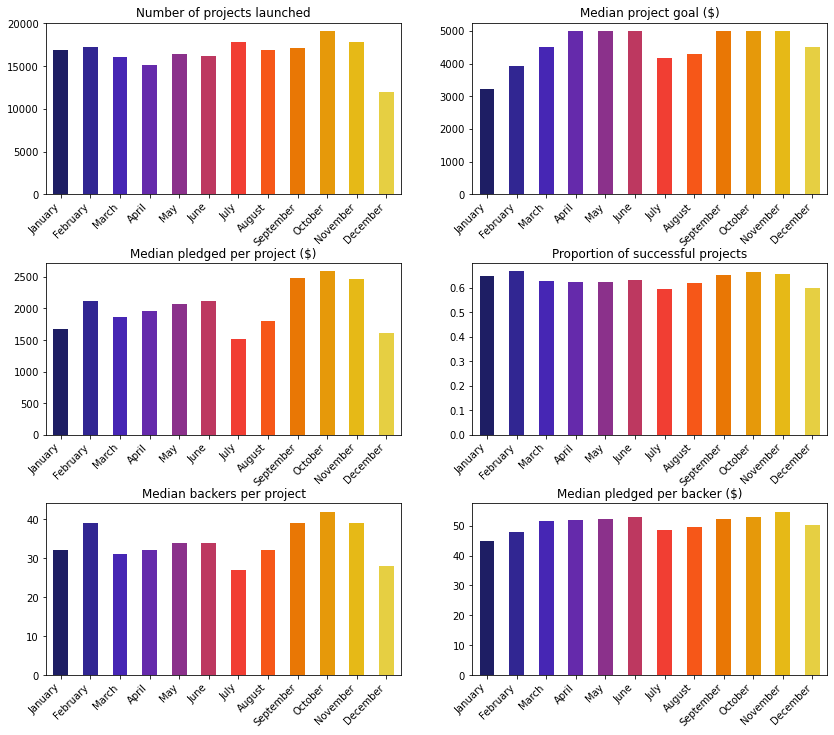

In [29]:
# Creating a dataframe grouped by the month in which they were launched, with columns for failed and successful
month_df = pd.get_dummies(df.set_index('launch_month').state).groupby('launch_month').sum()

# Plotting
months = list(calendar.month_name)[1:]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_month.nunique()))

df.groupby('launch_month').launch_month.count().reindex(months).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_goal.median().reindex(months).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_pledged.median().reindex(months).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

month_df.div(month_df.sum(axis=1), axis=0).successful.reindex(months).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

df.groupby('launch_month').backers_count.median().reindex(months).plot(kind='bar', ax=ax5, color=color, rot=45)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')
ax5.set_xticklabels(labels=ax5.get_xticklabels(), ha='right')

df.groupby('launch_month').pledge_per_backer.median().reindex(months).plot(kind='bar', ax=ax6, color=color, rot=45)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')
ax6.set_xticklabels(labels=ax6.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.4)
plt.show()

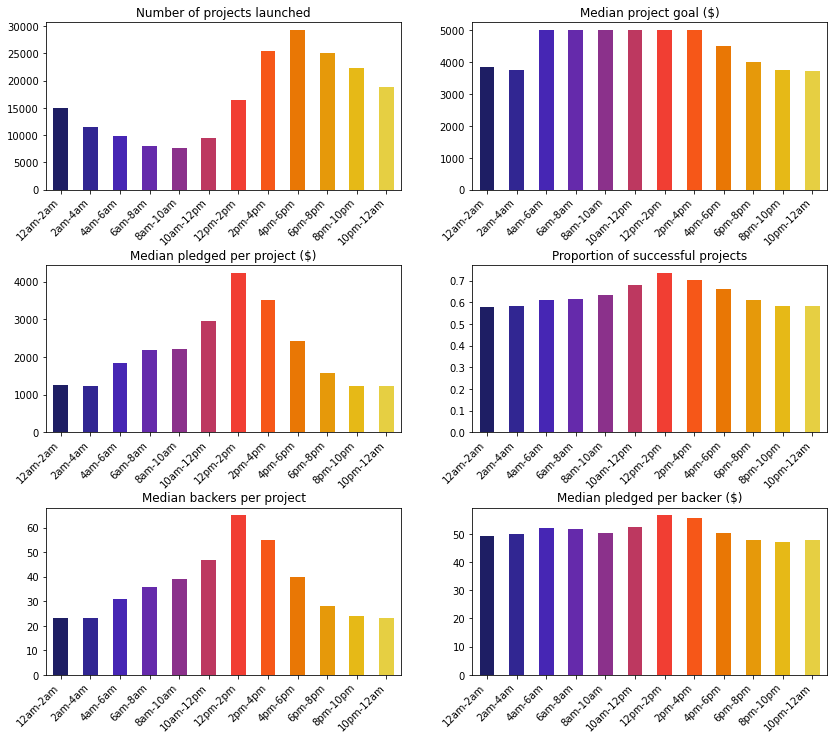

In [30]:
# Creating a dataframe grouped by the time at which they were launched, with columns for failed and successful
time_df = pd.get_dummies(df.set_index('launch_time').state).groupby('launch_time').sum()

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_time.nunique()))

times = ['12am-2am', '2am-4am', '4am-6am', '6am-8am', '8am-10am', '10am-12pm', '12pm-2pm', '2pm-4pm', '4pm-6pm', '6pm-8pm', '8pm-10pm', '10pm-12am']

df.groupby('launch_time').launch_time.count().reindex(times).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

df.groupby('launch_time').usd_goal.median().reindex(times).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

df.groupby('launch_time').usd_pledged.median().reindex(times).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

time_df.div(time_df.sum(axis=1), axis=0).successful.reindex(times).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

df.groupby('launch_time').backers_count.median().reindex(times).plot(kind='bar', ax=ax5, color=color, rot=45)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')
ax5.set_xticklabels(labels=ax5.get_xticklabels(), ha='right')

df.groupby('launch_time').pledge_per_backer.median().reindex(times).plot(kind='bar', ax=ax6, color=color, rot=45)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')
ax6.set_xticklabels(labels=ax6.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.45)
plt.show()

## class imbalance

In [31]:
df['state'].value_counts()

successful    125856
failed         72744
Name: state, dtype: int64

In [32]:
df_state_ = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

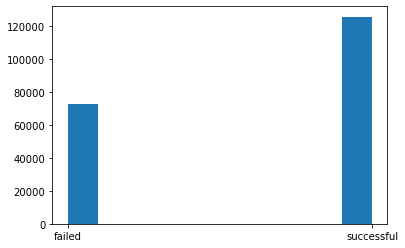

In [33]:
fig,ax=plt.subplots()
ax.hist(df_state_['state']);